#### 2011년 1월 ~ 2012년 12월
* 날짜,/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있음<br>
* datetime: hourly date + timestamp  
* season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
* holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
* workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
* weather:  
    1 = 맑음, 약간 구름 낀 흐림  
    2 = 안개, 안개 + 흐림  
    3 = 가벼운 눈, 가벼운 비 + 천둥  
    4 = 심한 눈/비, 천둥/번개  
* temp: 온도(섭씨)   
* atemp: 체감온도(섭씨)  
* humidity: 상대습도  
* windspeed: 풍속  
* **casual: 사전에 등록되지 않는 사용자가 대여한 횟수**  
* **registered: 사전에 등록된 사용자가 대여한 횟수**  
* count: 대여 횟수

#### 조건
* Score : RMSLE(Root Mean Squared Logarithmic Error)
  * 과대평가된 항목보다 과소평가 된 항목에 페널티를 준다. 0에 가까울 수록 정밀도가 높다.
* Submission Format : (datetime + timestamp), count
* Model : Random forest

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
# Mean squared logarithmic error regression loss.
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결

#### 전처리 시각화

In [171]:
bike_df = pd.read_csv('../ml/data/bike/train.csv')
bike_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [172]:
bike_df.tail(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [173]:
# head와 tail을 보고 날짜 기준을 확인 2011-01-01 ~ 2012-12-19까지
# info 를 통해 컬럼별 결측치와 데이터 타입확인
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [174]:
# 날짜의 데이터 타입이 문자열로 되어있어 pandas.to_datetime을 사용해 datetime 데이터 타입으로 변경
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [175]:
# datetime 데이터 형태로 머신러닝을 돌릴 수 없기 때문에 데이터 형태 변환
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
print(bike_df.info())
bike_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [176]:
# train 하지 않을 컬럼 삭제
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

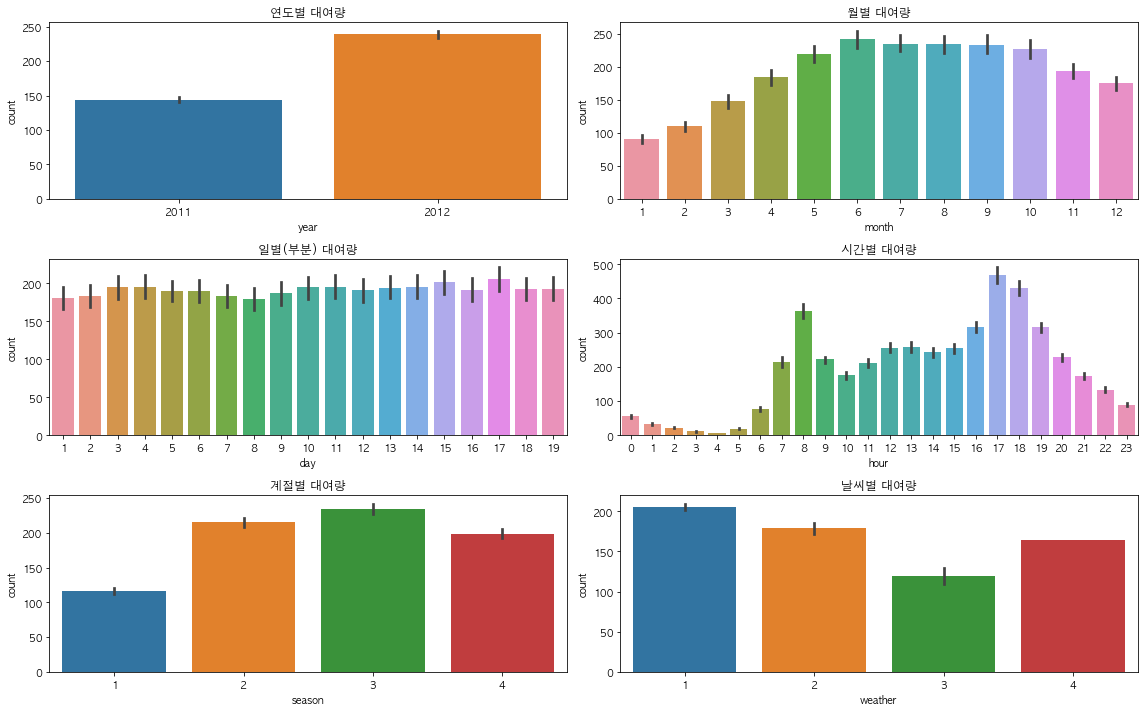

In [177]:
# 시간/계절/날씨별 자전거 대여량 시각화
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(16,10)

sns.barplot(data=bike_df, x="year", y="count", ax=ax1)
sns.barplot(data=bike_df, x="month", y="count", ax=ax2)
sns.barplot(data=bike_df, x="day", y="count", ax=ax3)
sns.barplot(data=bike_df, x="hour", y="count", ax=ax4)
sns.barplot(data=bike_df, x="season", y="count", ax=ax5)
sns.barplot(data=bike_df, x="weather", y="count", ax=ax6)

ax1.set(title="연도별 대여량")
ax2.set(title="월별 대여량")
ax3.set(title="일별(부분) 대여량")
ax4.set(title="시간별 대여량")
ax5.set(title="계절별 대여량")
ax6.set(title="날씨별 대여량")
plt.tight_layout()

In [178]:
# x, y 세팅
y = bike_df['count']
X = bike_df.drop('count', axis=1, inplace=False)
print(X.head(2))
print()
print()
print(y.head(2))

   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   

   year  month  day  hour  
0  2011      1    1     0  
1  2011      1    1     1  


0    16
1    40
Name: count, dtype: int64


In [179]:
# 전처리 함수화
def preprocessing_df(df):
    df['datetime'] = df['datetime'].apply(pd.to_datetime)
    df['year'] = df.datetime.apply(lambda x : x.year)
    df['month'] = df.datetime.apply(lambda x : x.month)
    df['day'] = df.datetime.apply(lambda x : x.day)
    df['hour'] = df.datetime.apply(lambda x : x.hour)
    return df

In [180]:
bike_df.keys()

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour'],
      dtype='object')

#### 파이프라인

In [181]:
X_train, X_test, v_train, v_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 연속형 변수 열 입력
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed']
numeric_transformer = StandardScaler()

# 범주형 변수 열 입력
categorical_features = ['season', 'weather', 'year', 'month', 'day', 'hour', 'holiday', 'workingday']
# 범주형 데이터가 x_train, x_test에 고르게 들어가지 않는 경우 pass 하기 위해 handel_unknown param ='ignore' 로 설정
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

preprocessor = ColumnTransformer(transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('rf_reg', RandomForestRegressor())])

In [182]:
# rmsle 함수화
def rmsle(y, pred):
    rmsle = np.sqrt(mean_squared_log_error(y, pred))
    return rmsle

In [184]:
pipeline.fit(X_train, v_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'weather', 'year',
                                                   'month', 'day', 'hour',
                                                   'holiday',
                                                   'workingday'])])),
                ('rf_reg', RandomForestRegressor())])

In [185]:
y_pred = pipeline.predict(X_test)
v_rmsle = rmsle(v_test, y_pred)
print(f'Validation set의 Score는 : {v_rmsle:.2f}')

Validation set의 Score는 : 0.47


In [186]:
y_pred[:5]

array([146.56,  26.79, 165.  , 221.21, 188.06])

#### Test set preprocessing

In [125]:
test_df = pd.read_csv('../ml/data/bike/test.csv')
test_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [126]:
test_df= preprocessing_df(test_df)
test_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1


In [129]:
test_X = test_df.drop('datetime', axis=1, inplace=False)
test_X.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1


In [128]:
pred_test = pipeline.predict(test_X)
pred_test.shape

(6493,)

In [137]:
# np.rint - 가장 가까운 정수로 반올림(반환은 float64)
bike_sub = pd.DataFrame()
bike_sub['datetime'] = test_df['datetime']
bike_sub['count'] = np.rint(pred_test)

In [140]:
bike_sub['count'] = bike_sub['count'].astype('int')
bike_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  6493 non-null   datetime64[ns]
 1   count     6493 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 101.6 KB


In [144]:
# score 0.55418
bike_sub.to_csv('../ml/data/bike/bike_submission.csv', encoding='utf-8', index=False)

#### 점수 올리기

In [196]:
# Pipeline 속 RandomForest Parameter 변경
pipeline.set_params(rf_reg__n_estimators=300)
pipeline.fit(X_train, v_train)
pred_test = pipeline.predict(test_X)

In [200]:
y_pred = pipeline.predict(X_test)
v_rmsle2 = rmsle(v_test, y_pred)
print(f'두번째 Validation set의 Score는 : {v_rmsle2:.2f}')

두번째 Validation set의 Score는 : 0.46


In [201]:
bike_sub = pd.DataFrame()
bike_sub['datetime'] = test_df['datetime']
bike_sub['count'] = np.rint(pred_test)
bike_sub['count'] = bike_sub['count'].astype('int')

In [202]:
bike_sub.to_csv('../ml/data/bike/bike_submission2.csv', encoding='utf-8', index=False)

#### n_estimators 스코어를 300, 500, 800 조절 해봤으나 큰 변화가 없음.